In [2]:
import cv2
import numpy as np
# import dlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

In [5]:
def find_distracted (students):
        
    var_o_var = []
    for s in students:
        
        nt = students [s] ['df'].values [33].tolist()
        ntx = nt [0::2]
        mean = np.mean (ntx)
        sigma = np.std (ntx)
        sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])

        var_o_var.append (sigmanorm)
        
    sigma_s = np.std (var_o_var)
    
    mean_s = np.mean (var_o_var)
    
    disturbed = []
    print ("threshold: ", mean_s + sigma_s)
    for i in range (len (var_o_var)):
        print (var_o_var [i])
        if var_o_var [i] >= mean_s + sigma_s:
            disturbed.append ((i+1))
            
    return disturbed
        


In [6]:
find_distracted (students)

NameError: name 'students' is not defined

In [7]:
def find_face1 (x1,y1,stu):
    
    maxx = 0.0
    maxy = 0.0
    sdnt = ''
    flag = 0
    
    for s in stu:
        temp1 = norm.pdf (x1, np.mean (stu [s] ['x1']), stu [s]['sd'])
        temp2 = norm.pdf (y1 ,np.mean (stu [s] ['y1']), stu [s]['sd'])
        if (temp1 > maxx and temp1 > 0.00000001):
            maxx = temp1
            if(temp2 > maxy and temp2 > 0.00000001):
                maxy = temp2
                sdnt = s
                flag = 1
            
    if (flag == 0):
        stu [len (stu) + 1] = {'x1': [x1],'y1':[y1], 'df':pd.DataFrame (), 'sd': 10}
        return (len (stu), stu)
    
    stu [sdnt] ['x1'].append (x1)
    stu [sdnt] ['y1'].append (y1)
    return (sdnt, stu)

In [8]:
def find_face2 (x1, y1 , stu):
    
    max = 0.0
    sdnt = ''
    flag = 0
    
    for s in stu:
        temp = norm.pdf (x1, np.mean (stu [s] ['x1']), stu [s]['sd'])
        if (temp > max and temp > 0.00000001):
            max = temp
            sdnt = s
            flag = 1
            
    if (flag == 0):
        stu [len (stu) + 1] = {'x1': [x1],'y1':[y1], 'df':pd.DataFrame (), 'sd': 10}
        return (len (stu), stu)
    
    stu [sdnt] ['x1'].append (x1)
    stu [sdnt] ['y1'].append (y1)
    return (sdnt, stu)

In [9]:
df = pd.DataFrame()
students = {}
distracted = []

cap = cv2.VideoCapture(0)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/home/dheeraj/my_projects/my_project_env/practice/Smart_Monitoring_System/shape_predictor_68_face_landmarks.dat")

for i in range(300):
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    
    for face in faces:
        
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
        
        #f, students = find_face (x1, x2, students)
        f, students = find_face1(x1, y1, students)
        #f, students = find_face2(x1, y1, students)
        
        print ("student (f): ", f)
        print ("distracted: ", distracted)
        if f in distracted:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
        else:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        landmarks = predictor(gray, face)
        xc = []
        yc = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            xc.append(x)
            yc.append(y)
            cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)
            
        students [f] ['df'] ['x'+str(i)] = xc
        students [f] ['df'] ['y'+str(i)] = yc
        students [f] ['box'] = list ((x1, x2))
    
    cv2.imshow("Frame", frame)
    print (len (students))
    
    distracted = find_distracted (students)
    

    key = cv2.waitKey(1)
    if key == 27:
        break
        
cap.release ()
cv2.destroyAllWindows ()

NameError: name 'dlib' is not defined

In [61]:
cap = cv2.VideoCapture(0)

for i in range (50):
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.rectangle (frame, (0, 0), (300, 350), (255, 0, 0), 3)
    cv2.imshow("Frame", frame)
    
    key = cv2.waitKey(1)
    if key == 27:
        break
    
cap.release ()
cv2.destroyAllWindows ()

In [28]:
def scaling:
    

SyntaxError: invalid syntax (<ipython-input-28-a760616ac932>, line 1)

In [15]:
len (students)

1

In [49]:
cap.release ()
cv2.destroyAllWindows ()

In [ ]:
students

In [9]:
for s in students:
    
    print (students [s] ['box'])

[228, 377]
[286, 411]


1
[253, 256, 256, 257, 269, 279, 282, 282, 283, 284, 285, 286, 287, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 292, 292, 293, 293, 296, 296, 298, 299, 299, 299, 300, 301, 301, 302, 303, 303, 304, 304, 306, 306, 307, 307, 308, 309, 310, 310, 311, 312, 312, 313, 313, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 317, 317, 318, 318, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 322, 322, 323, 323, 323, 324, 324, 325, 325, 326, 327, 327, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 330, 330, 331, 331, 331, 331, 332, 333, 334, 334, 335, 336, 338, 338, 338, 339, 340, 340, 341, 342, 342, 342, 342, 343, 343, 344, 344, 344, 344, 345, 345, 349, 351, 352, 354, 354, 356, 356, 357, 357]
125
20.466546920698246
0.16373237536558596
2
[539, 539, 539, 539, 540, 540, 540, 543, 543, 543, 543, 543, 543, 544, 544, 5

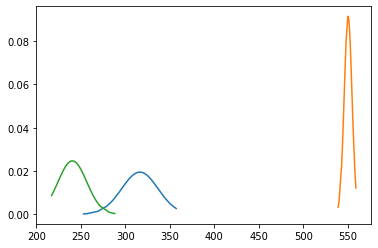

In [63]:
for s in students:
    
    nt = students [s] ['df'].values [33].tolist()
    ntx = nt [0::2]
    ntx.sort()
    mean = np.mean (ntx)
    sigma = np.std (ntx)
    sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])
    #plt.ylim ((0, 1))
    plt.plot (ntx, norm.pdf (ntx, mean, sigma))
    #plt.show ()
    print (s)
    print (ntx)
    print (students [s]['box'][1] - students[s]['box'][0])
    print (sigma)
    print (sigmanorm)

plt.show ()

In [64]:
for s in students:
    
    print (students [s] ['box'])

[203, 328]
[517, 589]
[162, 286]


In [65]:
find_distracted (students)

threshold:  0.16116188131789258
0.163732375365586
0.06041860648019442
0.13022467724811987


[1]

In [ ]:
cap.release ()
cv2.destroyAllWindows ()

In [ ]:
norm.pdf (350, 450, 15)

In [ ]:
students [1] ['df']